In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, SamplingMethod, System, OptimizerType, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    r"\sigma_t^q": "sigq",
    r"\sigma_t^\theta": "sigtheta",
    r"\sigma_t^\eta": "sige",
    r"\mu_t^\eta": "mue",
    r"\mu_t^q": "muq",
    r"\mu_t^\theta": "mutheta",


    r"\rho": "rho",
    r"\underline{a}": "ah",
    r"\underline{\delta}": "deltah",
    r"\delta": "deltae",
    r"\sigma": "sig",
    r"\kappa": "kappa",

    r"\eta": "e",

    r"\theta": "theta",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "phi",

}

## basic

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 200,
 "num_epochs": 10000,
 "lr": 0.0001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State V

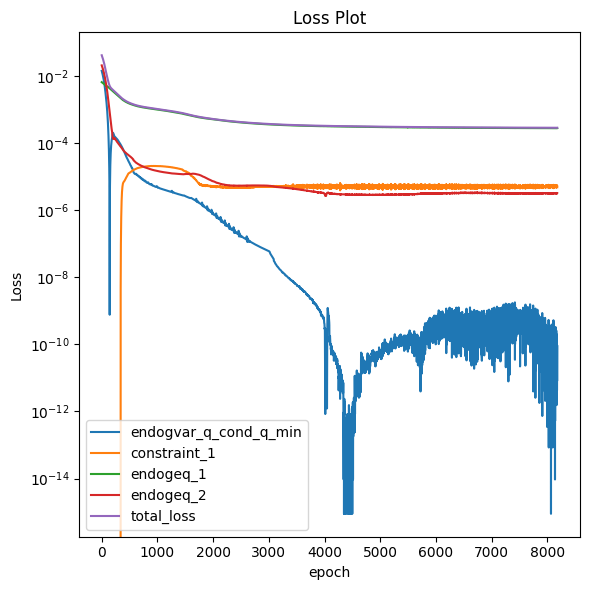

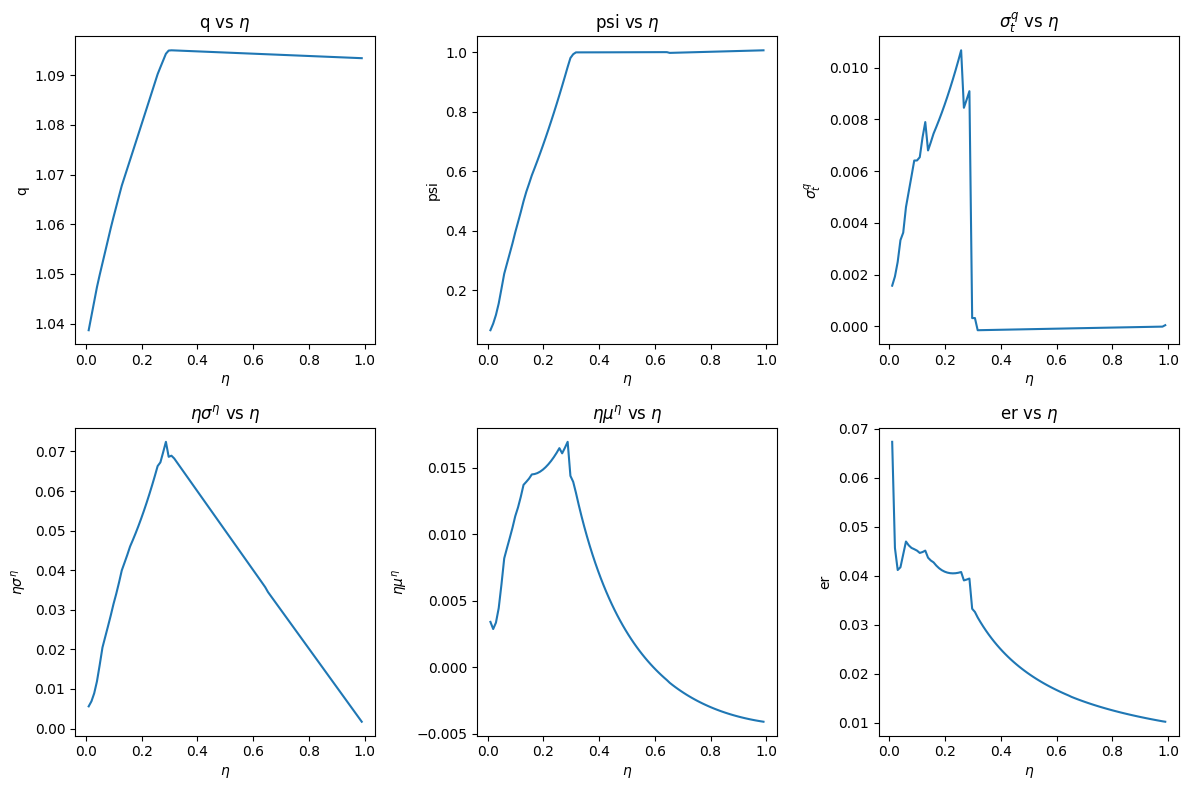

In [3]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"sampling_method": SamplingMethod.FixedGrid, "batch_size": 200,
    "num_epochs": 10000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam, 
    "loss_balancing": False, "lr": 1e-4, "bernoulli_prob": 0.9, "loss_balancing_temp": 0.1, 
    "loss_soft_attention": False}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True,
        "hidden_units": [50, 50], 
        "activation_type": ActivationType.ReLU,
    },
    "psi": {
        "positive": True, 
        "hidden_units": [50, 50], 
        "activation_type": ActivationType.ReLU,
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)*r + (q(SV) * q(SV) - 1) / (2*kappa) - ah", {"SV": torch.zeros((1, 1)), 
                                                                                 "r": 0.05, "ah": .07, "kappa": 2,},
                              Comparator.EQ,
                              "0", {},
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")
pde_model.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility_relu_base/model.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_relu_base", "model.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_base/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_base/model_best.pt"))
    pde_model.eval_model(True)

plot_loss_df(fn="./models/BruSan14_log_utility_relu_base/model_min_loss.csv", loss_plot_fn="./models/BruSan14_log_utility_relu_base/model_min_loss.jpg")
pde_model.plot_vars(["q", "psi",
                    r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)

## RARG

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 200,
 "num_epochs": 10000,
 "lr": 0.0001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "RAR-G",
 "loss_balancing": false,
 "bernoulli_prob": 0.9,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Varia

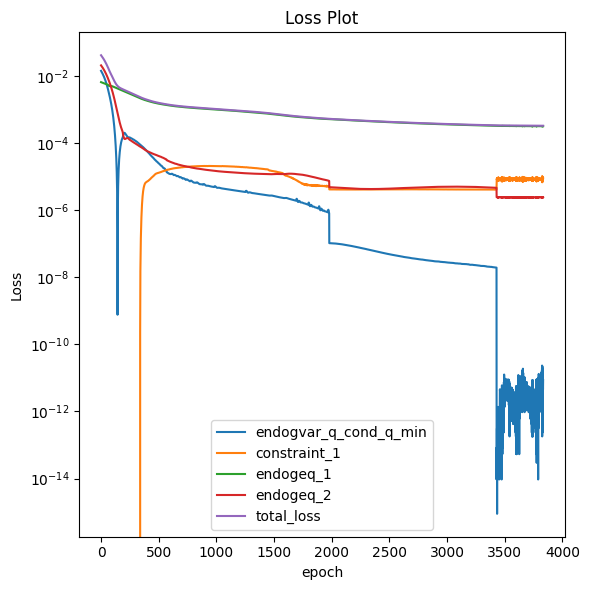

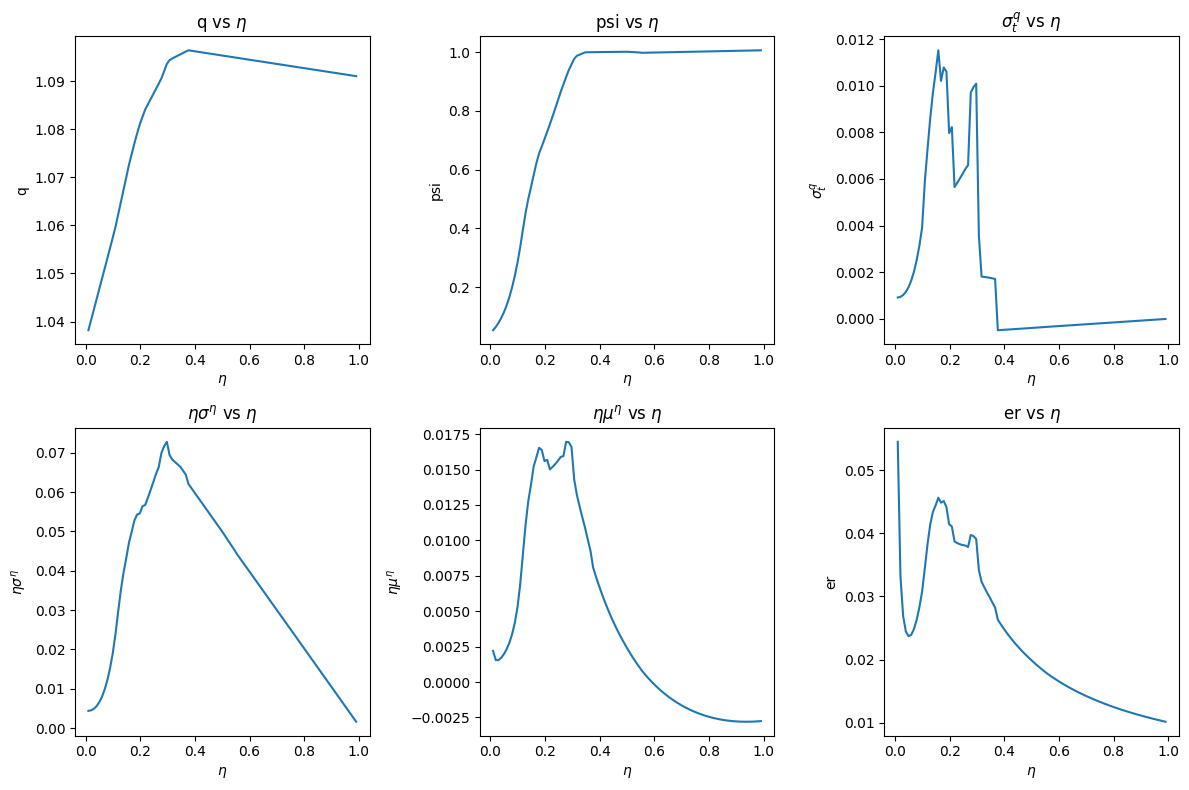

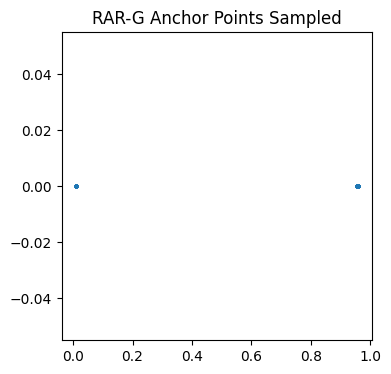

In [4]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"sampling_method": SamplingMethod.RARG, "batch_size": 200,
    "num_epochs": 10000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam, 
    "loss_balancing": False, "lr": 1e-4, "bernoulli_prob": 0.9, "loss_balancing_temp": 0.1, 
    "loss_soft_attention": False}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True,
        "hidden_units": [50, 50], 
        "activation_type": ActivationType.ReLU,
    },
    "psi": {
        "positive": True, 
        "hidden_units": [50, 50], 
        "activation_type": ActivationType.ReLU,
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)*r + (q(SV) * q(SV) - 1) / (2*kappa) - ah", {"SV": torch.zeros((1, 1)), 
                                                                                 "r": 0.05, "ah": .07, "kappa": 2,},
                              Comparator.EQ,
                              "0", {},
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")
pde_model.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility_relu_rarg/model.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_relu_rarg", "model.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_rarg/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_rarg/model_best.pt"))
    pde_model.eval_model(True)

plot_loss_df(fn="./models/BruSan14_log_utility_relu_rarg/model_min_loss.csv", loss_plot_fn="./models/BruSan14_log_utility_relu_rarg/model_min_loss.jpg")
pde_model.plot_vars(["q", "psi",
                    r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
anchor_points = np.load("./models/BruSan14_log_utility_relu_rarg/model_anchor_points.npy").reshape(-1)
ax.scatter(anchor_points, np.zeros_like(anchor_points), s=4)
ax.set_title("RAR-G Anchor Points Sampled")
plt.show()

Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
constraint_1: 0.0000,
endogeq_1: 0.0003,
endogeq_2: 0.0000,
total_loss: 0.0003


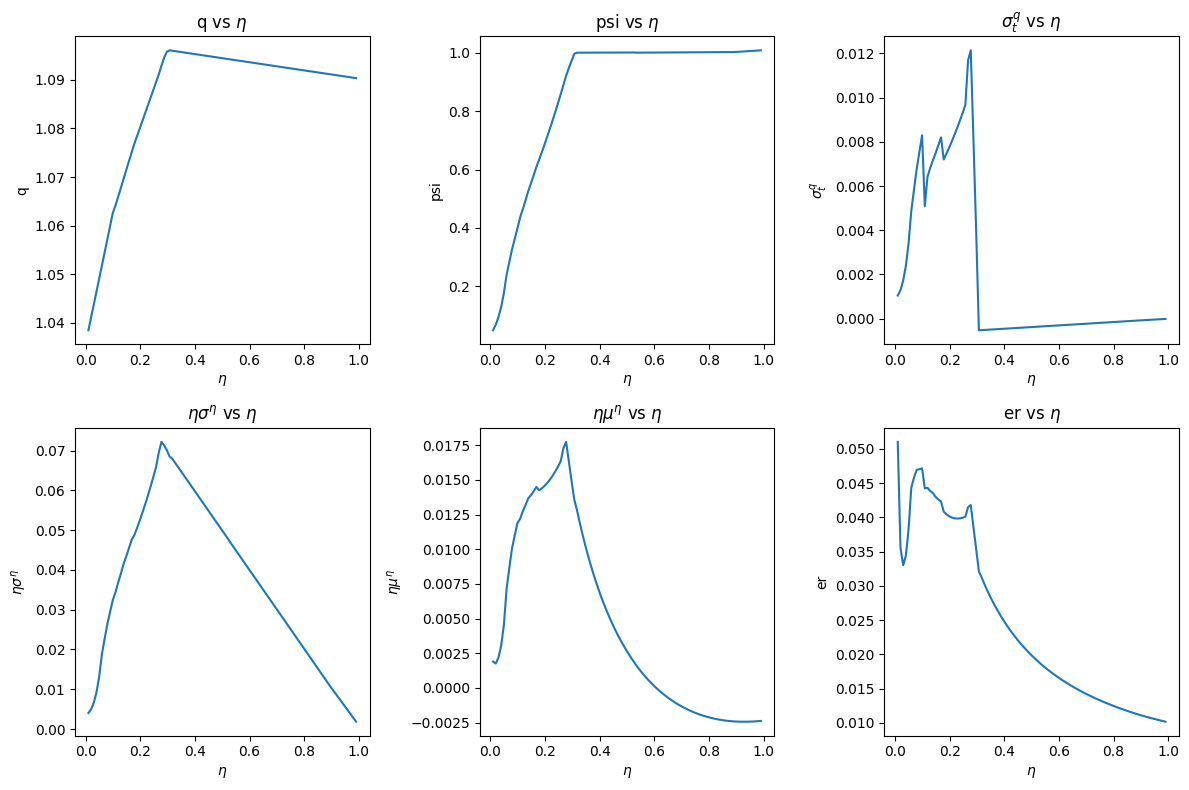

In [5]:
pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_rarg/model.pt"))
pde_model.eval_model(True)
pde_model.plot_vars(["q", "psi",
                    r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)

## RARD

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 200,
 "num_epochs": 10000,
 "lr": 0.0001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "RAR-D",
 "loss_balancing": false,
 "bernoulli_prob": 0.9,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Varia

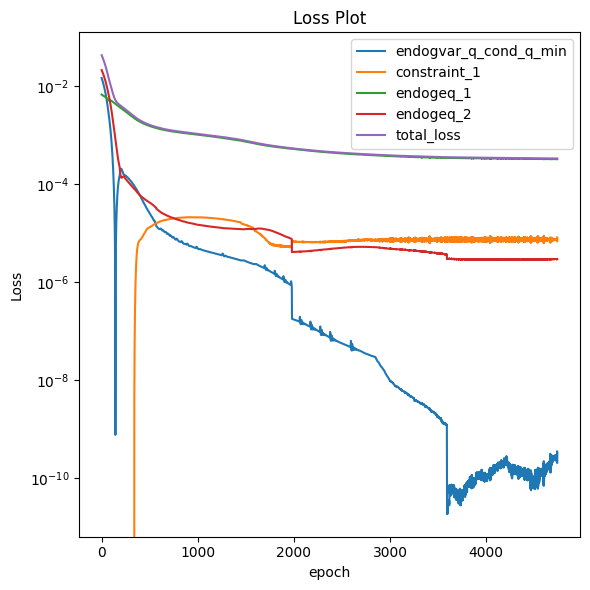

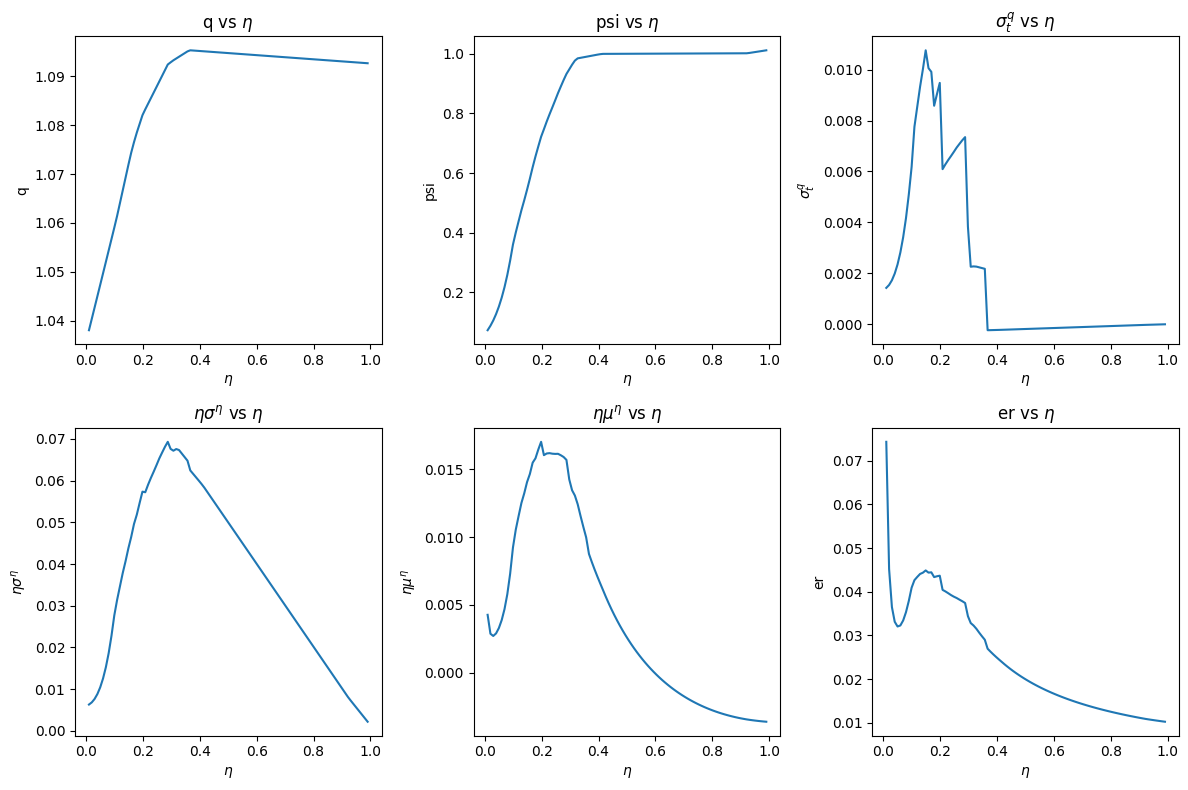

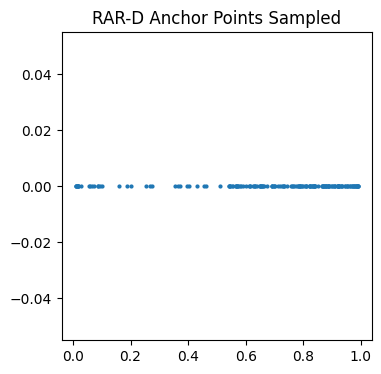

In [6]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"sampling_method": SamplingMethod.RARD, "batch_size": 200,
    "num_epochs": 10000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam, 
    "loss_balancing": False, "lr": 1e-4, "bernoulli_prob": 0.9, "loss_balancing_temp": 0.1, 
    "loss_soft_attention": False}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True,
        "hidden_units": [50, 50], 
        "activation_type": ActivationType.ReLU,
    },
    "psi": {
        "positive": True, 
        "hidden_units": [50, 50], 
        "activation_type": ActivationType.ReLU,
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)*r + (q(SV) * q(SV) - 1) / (2*kappa) - ah", {"SV": torch.zeros((1, 1)), 
                                                                                 "r": 0.05, "ah": .07, "kappa": 2,},
                              Comparator.EQ,
                              "0", {},
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")
pde_model.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility_relu_rard/model.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_relu_rard", "model.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_rard/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_rard/model_best.pt"))
    pde_model.eval_model(True)

plot_loss_df(fn="./models/BruSan14_log_utility_relu_rard/model_min_loss.csv", loss_plot_fn="./models/BruSan14_log_utility_relu_rard/model_min_loss.jpg")
pde_model.plot_vars(["q", "psi",
                    r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
anchor_points = np.load("./models/BruSan14_log_utility_relu_rard/model_anchor_points.npy").reshape(-1)
ax.scatter(anchor_points, np.zeros_like(anchor_points), s=4)
ax.set_title("RAR-D Anchor Points Sampled")
plt.show()

Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
constraint_1: 0.0000,
endogeq_1: 0.0003,
endogeq_2: 0.0000,
total_loss: 0.0003


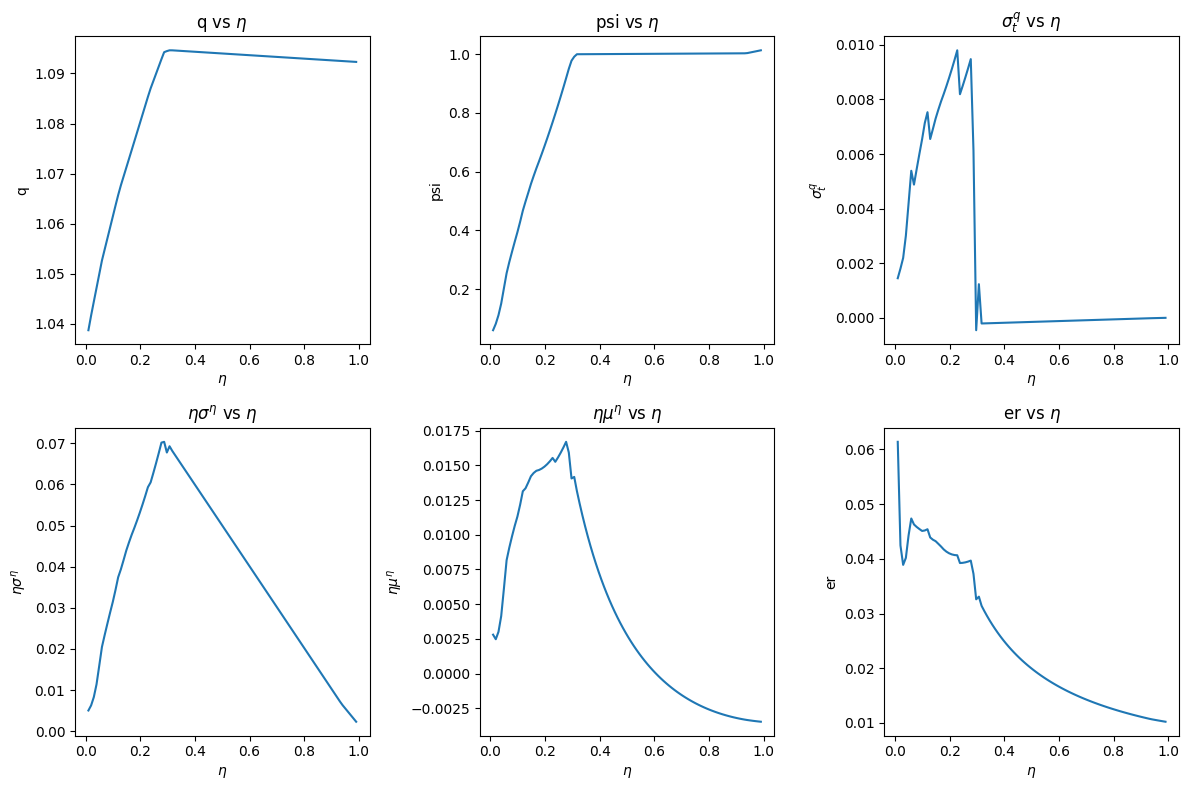

In [7]:
pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_rard/model.pt"))
pde_model.eval_model(True)
pde_model.plot_vars(["q", "psi",
                    r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)

## Soft Attention

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 200,
 "num_epochs": 10000,
 "lr": 0.0001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": true
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Va

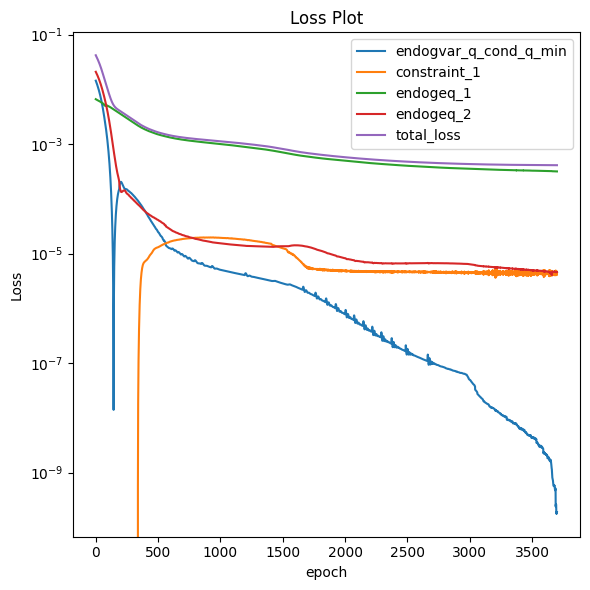

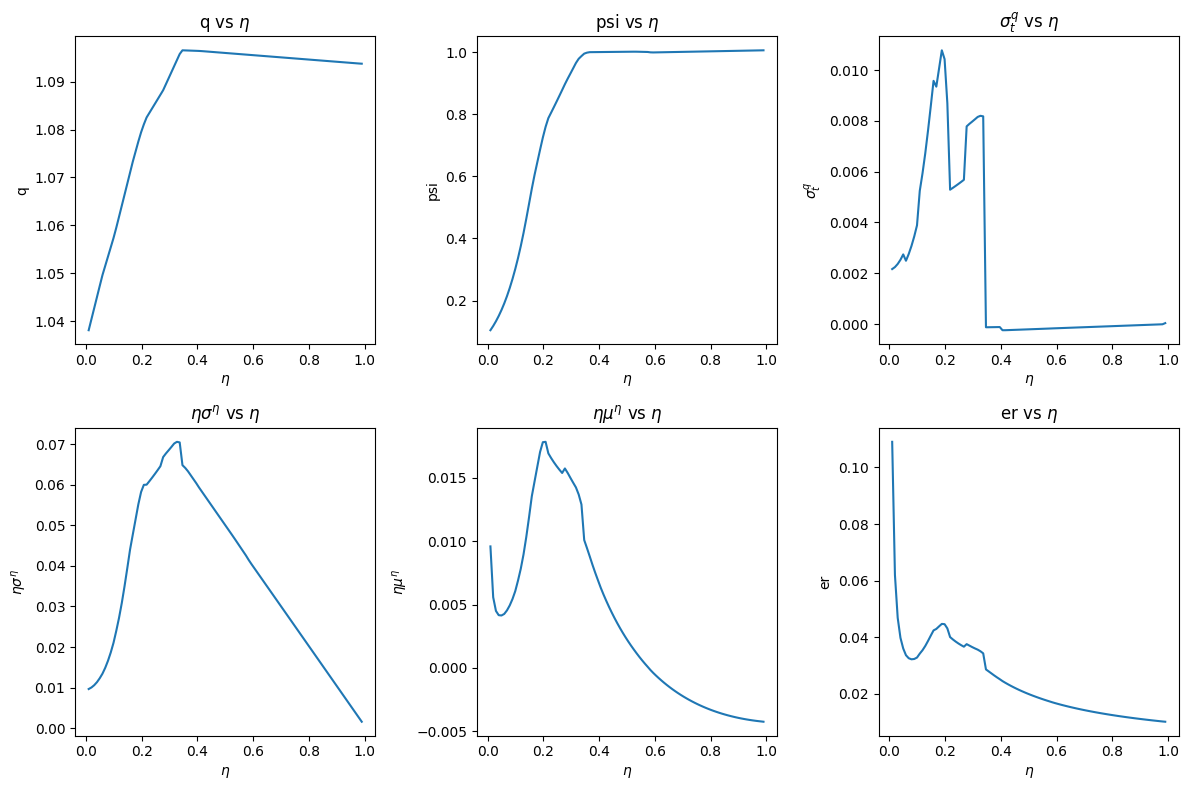

In [8]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"sampling_method": SamplingMethod.FixedGrid, "batch_size": 200,
    "num_epochs": 10000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam, 
    "loss_balancing": False, "lr": 1e-4, "bernoulli_prob": 0.9, "loss_balancing_temp": 0.1, 
    "loss_soft_attention": True}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True,
        "hidden_units": [50, 50], 
        "activation_type": ActivationType.ReLU,
    },
    "psi": {
        "positive": True, 
        "hidden_units": [50, 50], 
        "activation_type": ActivationType.ReLU,
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)*r + (q(SV) * q(SV) - 1) / (2*kappa) - ah", {"SV": torch.zeros((1, 1)), 
                                                                                 "r": 0.05, "ah": .07, "kappa": 2,},
                              Comparator.EQ,
                              "0", {},
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")
pde_model.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility_relu_soft_attention/model.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_relu_soft_attention", "model.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_soft_attention/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_soft_attention/model_best.pt"))
    pde_model.eval_model(True)
plot_loss_df(fn="./models/BruSan14_log_utility_relu_soft_attention/model_min_loss.csv", 
             loss_plot_fn="./models/BruSan14_log_utility_relu_soft_attention/model_min_loss.jpg")
pde_model.plot_vars(["q", "psi",
                    r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)

1.0000019073486328
1.8922399282455444


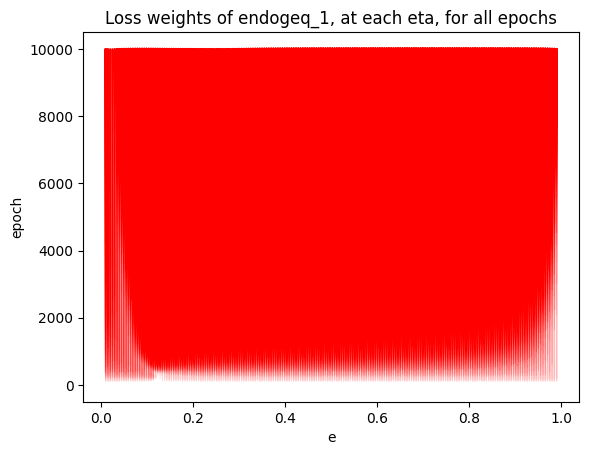

In [9]:
loss_weight_df = pd.read_csv("./models/BruSan14_log_utility_relu_soft_attention/model_loss_weight.csv").dropna()
# we consider endogeq_1 only
loss_weight_df = loss_weight_df[["epoch", "e", "endogeq_1"]]
unique_points = loss_weight_df["e"].unique()

max_val = loss_weight_df["endogeq_1"].max()
min_val = loss_weight_df["endogeq_1"].min()
print(min_val)
print(max_val)

for e in unique_points:
    curr_df = loss_weight_df[loss_weight_df["e"] == e]
    y_pos = curr_df["epoch"].values
    x_pos = [e] * len(y_pos)
    alpha = (curr_df["endogeq_1"] - min_val) / (max_val - min_val)
    plt.scatter(x_pos, y_pos, s = alpha, c="red", alpha=alpha)
plt.title("Loss weights of endogeq_1, at each eta, for all epochs")
plt.ylabel("epoch")
plt.xlabel("e")
plt.show()

Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
constraint_1: 0.0000,
endogeq_1: 0.0003,
endogeq_2: 0.0000,
total_loss: 0.0003


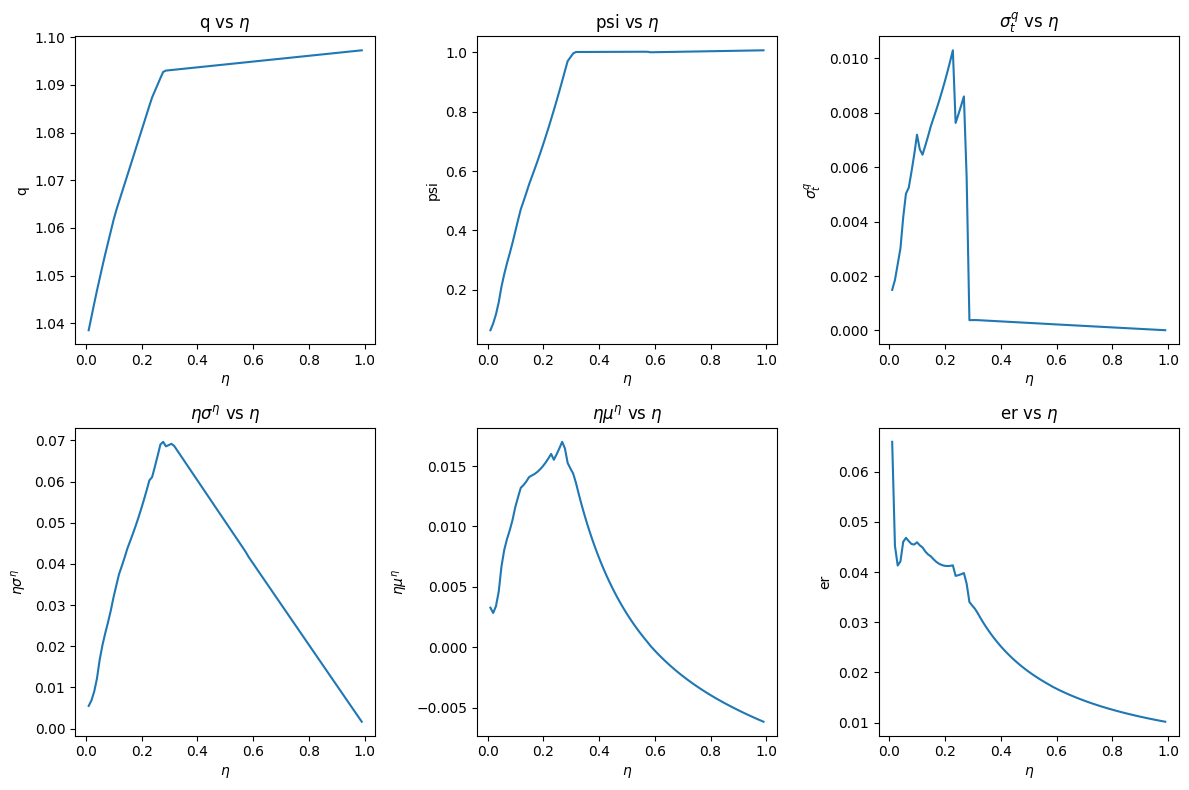

In [10]:
pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_soft_attention/model.pt"))
pde_model.eval_model(True)
pde_model.plot_vars(["q", "psi",
                    r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)

## Soft Adapt

=====================Summary of Model BruSan14_log_utility======================
Config: {
 "batch_size": 200,
 "num_epochs": 10000,
 "lr": 0.0001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid",
 "loss_balancing": true,
 "bernoulli_prob": 1.0,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.9,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\sigma_t^q": "sigq",
 "\\sigma_t^\\theta": "sigtheta",
 "\\sigma_t^\\eta": "sige",
 "\\mu_t^\\eta": "mue",
 "\\mu_t^q": "muq",
 "\\mu_t^\\theta": "mutheta",
 "\\rho": "rho",
 "\\underline{a}": "ah",
 "\\underline{\\delta}": "deltah",
 "\\delta": "deltae",
 "\\sigma": "sig",
 "\\kappa": "kappa",
 "\\eta": "e",
 "\\theta": "theta",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "phi"
}
User Defined Parameters:
{
 "sig": 0.1,
 "deltae": 0.05,
 "deltah": 0.05,
 "rho": 0.06,
 "r": 0.05,
 "a": 0.11,
 "ah": 0.07,
 "kappa": 2
}

================================State Vari

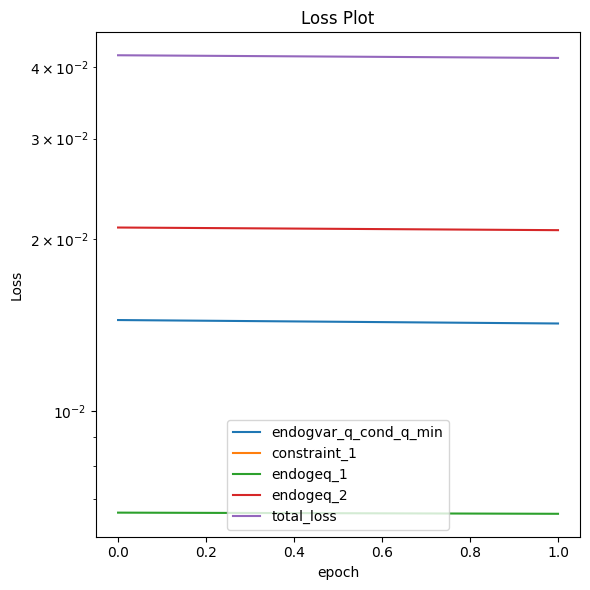

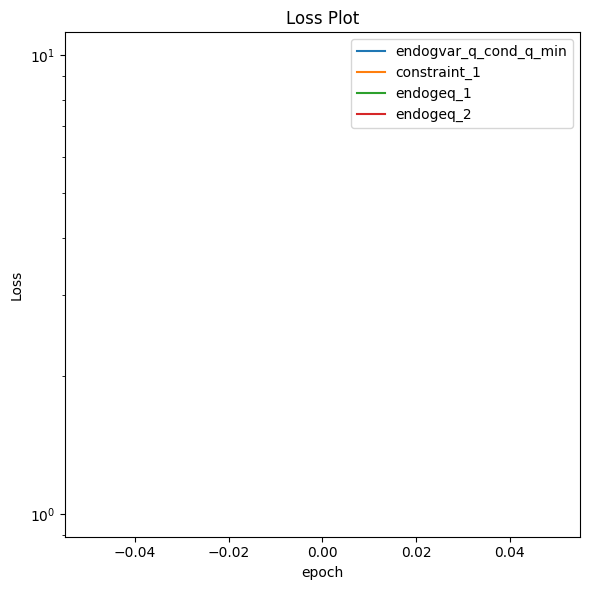

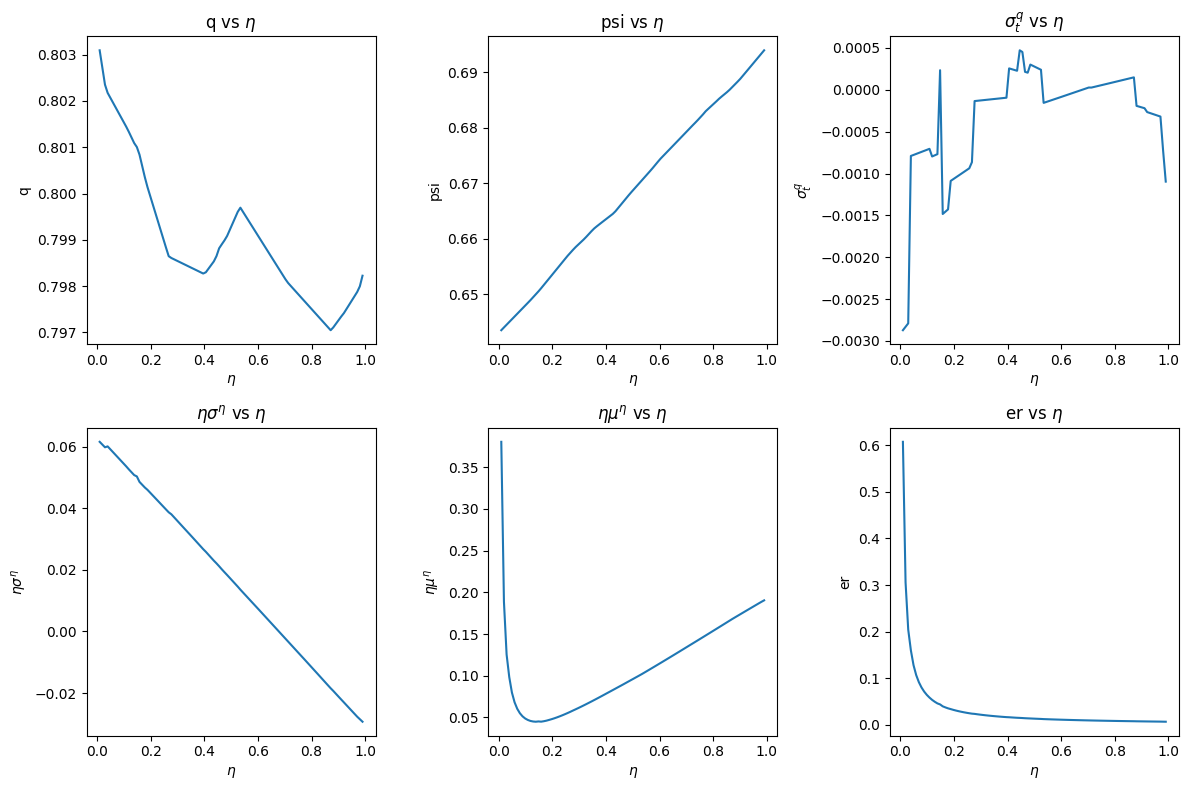

In [11]:
set_seeds(0)
pde_model = PDEModel("BruSan14_log_utility", {"sampling_method": SamplingMethod.FixedGrid, "batch_size": 200,
    "num_epochs": 10000, "loss_log_interval": 100, "optimizer_type": OptimizerType.Adam, 
    "loss_balancing": True, "lr": 1e-4, "bernoulli_prob": 1.0, "loss_balancing_alpha": 0.9, "loss_balancing_temp": 0.1, 
    "loss_soft_attention": False}, latex_var_mapping=latex_var_mapping)
pde_model.set_state(["e"], {"e": [0.01, 0.99]})
pde_model.add_endogs(["q", "psi"], configs={
    "q": {
        "positive": True,
        "hidden_units": [50, 50], 
        "activation_type": ActivationType.ReLU,
    },
    "psi": {
        "positive": True, 
        "hidden_units": [50, 50], 
        "activation_type": ActivationType.ReLU,
    }
})
pde_model.add_params({
    "sig": .1,
    "deltae": .05,
    "deltah": .05,
    "rho": .06,
    "r": .05,
    "a": .11,
    "ah": .07,
    "kappa": 2,
})
pde_model.add_endog_condition("q", 
                              "q(SV)*r + (q(SV) * q(SV) - 1) / (2*kappa) - ah", {"SV": torch.zeros((1, 1)), 
                                                                                 "r": 0.05, "ah": .07, "kappa": 2,},
                              Comparator.EQ,
                              "0", {},
                              label="q_min")
pde_model.add_equation(r"$\iota = \frac{q^2-1}{ 2 * \kappa}$")
pde_model.add_equation(r"$\sigma_t^q = \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial \eta} * (\psi - \eta)} - \sigma$")
pde_model.add_equation(r"$\sigma_t^\eta = \frac{\psi - \eta}{\eta} * (\sigma + \sigma_t^q)$")
pde_model.add_equation(r"$\mu_t^\eta = (\sigma_t^\eta)^2 + \frac{a - \iota}{q} + (1-\psi) * (\underline{\delta} - \delta) - \rho$")

pde_model.add_constraint("psi", Comparator.LEQ, "1")
pde_model.add_endog_equation(r"$(\sigma + \sigma_t^q) ^2 * (\psi / \eta - (1-\psi) / (1-\eta)) = \frac{a - \underline{a}}{q} + \underline{\delta} - \delta$")
pde_model.add_endog_equation(r"$(r*(1-\eta) + \rho * \eta) * q = \psi * a + (1-\psi) * \underline{a} - \iota$")

print(pde_model)
if not os.path.exists("./models/BruSan14_log_utility_relu_soft_adapt/model.pt"):
    pde_model.train_model("./models/BruSan14_log_utility_relu_soft_adapt", "model.pt", True)
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_soft_adapt/model_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/BruSan14_log_utility_relu_soft_adapt/model_best.pt"))
    pde_model.eval_model(True)

plot_loss_df(fn="./models/BruSan14_log_utility_relu_soft_adapt/model_min_loss.csv", 
             loss_plot_fn="./models/BruSan14_log_utility_relu_soft_adapt/model_min_loss.jpg")
plot_loss_df(fn="./models/BruSan14_log_utility_relu_soft_adapt/model_loss_weight.csv", 
             loss_plot_fn="./models/BruSan14_log_utility_relu_soft_adapt/model_loss_weight.jpg")
pde_model.plot_vars(["q", "psi",
                    r"$\sigma_t^q$",
                     r"$\eta\sigma^\eta = \eta*\sigma_t^\eta$",
                     r"$\eta\mu^\eta = \eta*\mu_t^\eta$",
                     "er = psi/e*(sig+sigq)**2"], ncols=3)